## Мы анализируем, какие факторы определяют спрос на аренду самокатов. Данная информация необходима владельцам сервиса для перехода впоследствии на динамический тип ценообразования, который обеспечит бОльшую прибыльность проекту. Мы строим модель линейной регрессии, добавляя временнЫе переменные, чтобы выявить некторые тренды и проверяем гипотезы, придуманные ранее и на основе результатов моделирования

# Импорты

In [1]:
import pandas as pd
import csv
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer

In [3]:
# настроим цвета
palette = sns.dark_palette("#69d", reverse=True, as_cmap=True)

# Загрузка данных


In [4]:
rides = pd.read_csv('rides.csv', decimal='.', sep=',', na_values='')
rides.columns = rides.columns.str.lower().str.replace(' ', '_')

rides.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-Восточный,Западная,Ленинский,4879.0,0
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.0,0
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,ул. западная,Ленинский,3133.0,0
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,ленинский,Озерная,Юго-Восточный,3.0,0
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,ленинский,ул. чкалова,юго-восточный,5263.0,0


In [5]:
weather = pd.read_csv('weather.csv', decimal='.')
weather.columns = weather.columns.str.lower().str.replace(' ', '_')

weather.head(10)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0
5,2023-04-01T04:00:00,8.630245,0.3,48.96,22.42427,78,0
6,2023-04-01T05:00:00,8.430245,0.5,48.6,22.91026,77,0
7,2023-04-01T06:00:00,8.690246,0.3,50.039997,23.1774,98,0.5287884
8,2023-04-01T07:00:00,8.860246,0.4,52.56,23.166216,89,6.060605
9,2023-04-01T08:00:00,8.640245,0.5,63,20.371038,92,4.242425


# Предобработка

### приведение данных к нормальным типам

In [6]:
# удалим первую поясняющую строку в weather
weather = weather.drop(index=0)

In [7]:
# разделим дату и время в столбце datetime в таблице weather
weather['datetime'] = weather.datetime.str.replace('T', ' ')

weather.head(10)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
1,2023-04-01 00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01 02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01 03:00:00,8.690246,0.3,55.44,21.94524,77,0
5,2023-04-01 04:00:00,8.630245,0.3,48.96,22.42427,78,0
6,2023-04-01 05:00:00,8.430245,0.5,48.6,22.91026,77,0
7,2023-04-01 06:00:00,8.690246,0.3,50.039997,23.1774,98,0.5287884
8,2023-04-01 07:00:00,8.860246,0.4,52.56,23.166216,89,6.060605
9,2023-04-01 08:00:00,8.640245,0.5,63,20.371038,92,4.242425
10,2023-04-01 09:00:00,8.730246,0.6,60.120003,23.838959,88,6.666666


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 1 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   datetime             3672 non-null   object
 1   temperature          3617 non-null   object
 2   precipitation_total  3642 non-null   object
 3   wind_gust            3672 non-null   object
 4   wind_speed           3656 non-null   object
 5   cloud_cover_total    3652 non-null   object
 6   sunshine_duration    3660 non-null   object
dtypes: object(7)
memory usage: 200.9+ KB


In [9]:
# приведем данные столбцов к нужным типам данных
weather['temperature'] = weather['temperature'].astype(float)
weather['precipitation_total'] = weather['precipitation_total'].astype(float)
weather['wind_gust'] = weather['wind_gust'].astype(float)
weather['wind_speed'] = weather['wind_speed'].astype(float)
weather['cloud_cover_total'] = weather['cloud_cover_total'].astype(float)
weather['sunshine_duration'] = weather['sunshine_duration'].astype(float)
weather['datetime'] = pd.to_datetime(weather['datetime'], format="%Y-%m-%d %H:%M:%S")

In [10]:
weather.describe()

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
count,3672,3617.000000,3642.000000,3672.000000,3656.000000,3652.000000,3660.000000
mean,2023-06-16 11:30:00.000000256,18.137779,0.101043,20.886568,7.345096,41.056216,21.502410
min,2023-04-01 00:00:00,-2.079755,0.000000,2.880000,0.000000,0.000000,0.000000
25%,2023-05-09 05:45:00,13.270246,0.000000,13.320000,4.334974,15.000001,0.000000
50%,2023-06-16 11:30:00,18.100245,0.000000,18.359999,6.287130,33.000000,14.919949
75%,2023-07-24 17:15:00,23.010244,0.000000,26.280000,9.449572,67.000000,42.454547
max,2023-08-31 23:00:00,36.150246,5.800000,71.280000,29.966620,100.000000,60.000000
std,NaN,6.848331,0.343670,10.436531,4.265649,31.318514,21.896528


In [11]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              102255 non-null  int64  
 1   start_date      102255 non-null  object 
 2   end_date        102255 non-null  object 
 3   start_location  102255 non-null  object 
 4   start_district  102255 non-null  object 
 5   end_location    102255 non-null  object 
 6   end_district    102255 non-null  object 
 7   distance        101022 non-null  float64
 8   promo           102255 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 7.0+ MB


In [12]:
# приводим данные к нужным типам
rides['start_date'] = pd.to_datetime(rides['start_date'], format='%Y-%m-%d %H:%M:%S')
rides['end_date'] = pd.to_datetime(rides['end_date'], format='%Y-%m-%d %H:%M:%S')


In [13]:
rides.describe()

,id,start_date,end_date,distance,promo
count,102255.000000,102255,101676,1.010220e+05,102255.000000
mean,149024.057679,2023-06-13 21:03:26.564109568,2023-06-13 21:12:30.483732224,2.729110e+04,0.019755
min,100340.000000,2023-04-22 09:01:03,2023-04-22 09:24:45,1.000000e+00,0.000000
25%,124682.500000,2023-05-20 21:41:13,2023-05-20 22:05:22.249999872,3.044000e+03,0.000000
50%,149028.000000,2023-06-14 15:22:15,2023-06-14 15:13:58,3.702000e+03,0.000000
75%,173372.500000,2023-07-08 19:53:17.500000,2023-07-08 20:07:05,4.429000e+03,0.000000
max,197711.000000,2023-07-31 23:57:01,2023-08-01 00:42:12,7.569789e+06,1.000000
std,28110.574992,NaN,NaN,3.097186e+05,0.139156


In [14]:
rides.select_dtypes('object').describe()

,start_location,start_district,end_location,end_district
count,102255,102255,102255,102255
unique,463,13,495,14
top,Ломоносова,Центральный,Спортивная,Центральный
freq,1675,18115,1511,18878


можем заметить пропуски в таблице weather в столбцах temperature, precipitation_total, wind_speed, cloud_cover_total, sunshine_duration.
Также пропуски в таблице rides в столбце distance.
Также видим, что некоторые одинаковые категориальные данные имеют разное написание (Октябрьский/октябрьский).


### заполнение пропусков

In [15]:
# Удалим явные дубликаты до обработки выбросов и пропусков, чтобы повторение не смещали средние статистики, которыми мы будем заполнять данные
rides = rides.drop_duplicates()
weather = weather.drop_duplicates()

In [16]:
# приводим строки к одному написанию
def streets_norm(street):
    try:
        street = street.replace('.', ' ')
        if "ул " in street.lower():
            street = street[3:].strip().rstrip()
        street = street.capitalize()
        return street
    except AttributeError:
        print(street)
        print(type(street))


# названия из 2 слов с заглавной буквы написаны некорректно с точки зрения языка, зато одинаково
rides['start_location'] = rides['start_location'].apply(streets_norm)
rides['end_location'] = rides['end_location'].apply(streets_norm)
rides['start_district'] = rides['start_district'].apply(streets_norm)
rides['end_district'] = rides['end_district'].apply(streets_norm)


rides.head(20)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-западный,Юбилейная,Юго-восточный,4029.0,0
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-восточный,Западная,Ленинский,4879.0,0
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.0,0
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.0,0
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-восточный,3.0,0
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-восточный,5263.0,0


In [17]:
rides['start_location'].unique()

array(['Шевченко', 'Чехова', 'Буденного', 'Труда', 'Первомайская',
       'Лесная', 'Пролетарская', 'Комарова', 'Западная', 'Свободы',
       'Коммунальная', 'Зеленая', 'Шоссейная', 'Центральная', 'Новая',
       'Энтузиастов', 'Подгорная', 'Восточная', 'Лермонтова', 'Школьная',
       'Пушкина', 'Рябиновая', 'Солнечная', 'Мичурина', 'Партизанская',
       'Вокзальная', 'Комсомольская', 'Майская', 'Красноармейская',
       'Рабочая', 'Почтовая', 'Дачная', 'Заводская', 'Ломоносова',
       'Карла маркса', 'Советская', 'Красная', 'Дзержинского',
       'Энергетиков', 'Пионерская', 'Ленина', 'Сиреневая', 'Гагарина',
       'Юбилейная', 'Цветочная', 'Набережная', 'Сосновая', 'Спортивная',
       'Полевая', 'Строительная', 'Озерная', 'Горького', 'Южная',
       'Некрасова', 'Молодежная', 'Чкалова', 'Речная', 'Парковая',
       'Строителей', 'Кирова', 'Матросова', 'Садовая', 'Колхозная',
       'Луговая', 'Крупской', 'Октябрьская', 'Березовая', 'Вишневая',
       'Береговая', 'Дружбы', 'Кали

In [18]:
rides['end_location'].unique()

array(['Майская', 'Спортивная', 'Суворова', 'Рабочая', 'Юбилейная',
       'Западная', 'Свободы', 'Озерная', 'Чкалова', 'Строителей',
       'Красная', 'Крупской', 'Почтовая', 'Гоголя', 'Сиреневая', 'Южная',
       'Шоссейная', 'Трудовая', 'Дружбы', 'Космонавтов', 'Шевченко',
       'Набережная', 'Вишневая', 'Совхозная', 'Сосновая', 'Куйбышева',
       'Степная', 'Береговая', 'Луговая', 'Свердлова', 'Матросова',
       'Березовая', 'Ломоносова', 'Первомайская', 'Вокзальная', 'Зеленая',
       'Ленина', 'Солнечная', 'Красноармейская', 'Железнодорожная',
       'Лермонтова', 'Карла маркса', 'Овражная', 'Строительная', 'Речная',
       'Заводская', 'Школьная', 'Чапаева', 'Коммунальная', 'Буденного',
       'Северная', 'Мира', 'Полевая', 'Садовая', 'Партизанская',
       'Заречная', 'Новая', 'Пионерская', 'Советская', 'Нагорная',
       'Энтузиастов', 'Дорожная', 'Колхозная', 'Рябиновая', 'Московская',
       'Гагарина', 'Подгорная', 'Энергетиков', 'Горького', 'Дзержинского',
       'Маяко

In [19]:
rides['start_district'].unique()

array(['Юго-восточный', 'Заречный', 'Октябрьский', 'Центральный',
       'Северо-западный', 'Ленинский', 'Северо западный'], dtype=object)

In [20]:
rides['end_district'].unique()

array(['Октябрьский', 'Ленинский', 'Северо-западный', 'Юго-восточный',
       'Центральный', 'Заречный', 'Северо западный'], dtype=object)

In [21]:
# видим еще пару неявных дупликатов
rides['start_district'] = rides['start_district'].replace('Северо западный', 'Северо-западный')
rides['end_district'] = rides['end_district'].replace('Северо западный', 'Северо-западный')

In [22]:
# посмотрим, сколько пропусков
rides['distance'].isna().sum()

1181

In [23]:
# посмотрим на них
check = rides[rides['distance'].isna()]
check.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
188,100517,2023-04-22 13:53:36,2023-04-22 14:16:43,Цветочная,Северо-западный,Мичурина,Ленинский,NaN,0
256,100582,2023-04-22 14:56:38,2023-04-22 15:36:18,Вишневая,Юго-восточный,Московская,Северо-западный,NaN,0
291,100615,2023-04-22 15:25:04,2023-04-22 15:42:43,Ломоносова,Октябрьский,Куйбышева,Центральный,NaN,0
501,100813,2023-04-22 18:02:47,2023-04-22 18:58:57,Почтовая,Юго-восточный,Солнечная,Центральный,NaN,0
515,100827,2023-04-22 18:10:22,2023-04-22 18:49:17,Школьная,Северо-западный,Юбилейная,Юго-восточный,NaN,0
637,100944,2023-04-22 19:18:20,2023-04-22 19:54:54,Пролетарская,Центральный,Заречная,Юго-восточный,NaN,0
866,101160,2023-04-22 21:26:18,2023-04-22 21:46:33,Дачная,Центральный,Комсомольская,Заречный,NaN,0
995,101283,2023-04-22 23:28:55,2023-04-23 00:15:28,Совхозная,Центральный,Чапаева,Северо-западный,NaN,0
1037,101322,2023-04-23 01:01:46,2023-04-23 01:47:24,Центральная,Юго-восточный,Партизанская,Ленинский,NaN,0
1193,101470,2023-04-23 11:26:28,2023-04-23 12:10:50,Речная,Юго-восточный,Пионерская,Заречный,NaN,0


In [24]:
# заменим пропуски в distance средним расстоянием поездки по данному часу

# Округление даты и времени в столбце start_date до часа
rides['rounded_start_date'] = rides['start_date'].dt.floor('h')

# Создание столбца среднего расстояния для каждого дня
rides['mean_distance_per_day'] = rides.groupby('rounded_start_date')['distance'].transform('mean')

# Замена пропусков средним расстоянием поездок за каждый день
rides['distance'].fillna(rides['mean_distance_per_day'], inplace=True)

# Удаление временного столбца mean_distance_per_day
rides.drop(columns=['mean_distance_per_day'], inplace=True)

In [25]:
rides[rides['distance'].isna()]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date
8889,108787,2023-05-02 03:08:43,2023-05-02 03:25:05,Горького,Юго-восточный,Комарова,Ленинский,NaN,0,2023-05-02 03:00:00


In [26]:
# остался один пропуск, заменим его средним по дню

# Определяем дату этой записи
date_of_missing_data = rides.loc[rides['id'] == 108787, 'start_date'].dt.floor('d').iloc[0]

# Получаем среднее расстояние поездок за этот день
mean_distance_for_day = rides.loc[rides['start_date'].dt.floor('d') == date_of_missing_data, 'distance'].mean()

# Заменяем пропуск средним расстоянием для этого дня
rides.loc[rides['id'] == 108787, 'distance'] = mean_distance_for_day

rides[rides['distance'].isna()]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date


In [27]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 102254
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  97372 non-null  int64         
 1   start_date          97372 non-null  datetime64[ns]
 2   end_date            96817 non-null  datetime64[ns]
 3   start_location      97372 non-null  object        
 4   start_district      97372 non-null  object        
 5   end_location        97372 non-null  object        
 6   end_district        97372 non-null  object        
 7   distance            97372 non-null  float64       
 8   promo               97372 non-null  int64         
 9   rounded_start_date  97372 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 8.2+ MB


In [28]:
rides[rides.end_date.isna()]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date
312,100636,2023-04-22 15:44:25,NaT,Мичурина,Ленинский,Кирова,Ленинский,3739.0,0,2023-04-22 15:00:00
407,100725,2023-04-22 16:52:47,NaT,Партизанская,Ленинский,Вишневая,Юго-восточный,2721.0,0,2023-04-22 16:00:00
486,100799,2023-04-22 17:51:45,NaT,Гагарина,Центральный,Партизанская,Ленинский,4789.0,0,2023-04-22 17:00:00
495,100807,2023-04-22 17:58:05,NaT,Ломоносова,Октябрьский,Цветочная,Северо-западный,4.0,0,2023-04-22 17:00:00
753,101049,2023-04-22 20:18:01,NaT,Чехова,Заречный,Садовая,Заречный,3496.0,0,2023-04-22 20:00:00
...,...,...,...,...,...,...,...,...,...,...
101262,196766,2023-07-31 06:12:05,NaT,Молодежная,Юго-восточный,Чехова,Заречный,4257.0,1,2023-07-31 06:00:00
101784,197260,2023-07-31 16:45:57,NaT,Вишневая,Юго-восточный,Восточная,Октябрьский,3302.0,0,2023-07-31 16:00:00
101961,197428,2023-07-31 19:16:20,NaT,Южная,Центральный,Чапаева,Северо-западный,4.0,0,2023-07-31 19:00:00
102108,197572,2023-07-31 20:51:23,NaT,Юбилейная,Юго-восточный,Дорожная,Юго-восточный,2940248.0,0,2023-07-31 20:00:00


In [29]:
# создаём столбик со временем поездки в секундах
def findtime(data):
    start = str(data['start_date'])
    end = str(data['end_date'])

    if end != 'NaT':
        startdatetime = datetime.strptime(str(start), '%Y-%m-%d %H:%M:%S')
        enddatetime = datetime.strptime(str(end), '%Y-%m-%d %H:%M:%S')
        new_time = (enddatetime - startdatetime)
        return new_time.total_seconds()


rides['trip_time_seconds'] = rides[['start_date', 'end_date']].apply(findtime, axis=1)

rides




,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date,trip_time_seconds
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-восточный,Майская,Октябрьский,4069.0,0,2023-04-22 09:00:00,1422.0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0,2023-04-22 09:00:00,1705.0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0,2023-04-22 09:00:00,2299.0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-западный,3881.0,0,2023-04-22 09:00:00,1909.0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-западный,Юбилейная,Юго-восточный,4029.0,0,2023-04-22 09:00:00,1840.0
...,...,...,...,...,...,...,...,...,...,...,...
102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,Озерная,Юго-восточный,Первомайская,Северо-западный,3302.0,0,2023-07-31 23:00:00,1309.0
102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,Мичурина,Ленинский,Садовая,Заречный,4992.0,0,2023-07-31 23:00:00,2374.0
102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,Лермонтова,Ленинский,Куйбышева,Центральный,2781.0,0,2023-07-31 23:00:00,1277.0
102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,Рябиновая,Северо-западный,Энергетиков,Юго-восточный,6466.0,0,2023-07-31 23:00:00,2783.0


In [30]:
rides.isna().sum()

id                      0
start_date              0
end_date              555
start_location          0
start_district          0
end_location            0
end_district            0
distance                0
promo                   0
rounded_start_date      0
trip_time_seconds     555
dtype: int64

In [31]:
# заполняем пропуски в end_date
# ищем все поездки, где совпадают начало и конец (либо конец и начало) с значениями в пропусках и берем среднее время
# еще можно наложить фильтр по времени суток поездки, но я думаю ,что это излишне
def nan_endtime(data):
    start = data['start_date']
    end = data['end_date']

    if str(end) == 'NaT':  # Проверяем, является ли 'end' NaN
        start = pd.to_datetime(start)  # Преобразуем 'start' в формат datetime
        pre_frame = rides.loc[
            (((rides.start_location == data.start_location) & (rides.end_location == data.end_location)) |
             ((rides.start_location == data.end_location) & (rides.end_location == data.start_location))),
            'trip_time_seconds'].mean()
        end = start + timedelta(seconds=pre_frame)  # прибавляем к началу рассчитанную длительность

    return end.replace(microsecond=0)


# заполняем end_date
rides['end_date'] = rides.apply(nan_endtime, axis=1)

# пересчитываем продолжительность поездок
rides['trip_time_seconds'] = rides[['start_date', 'end_date']].apply(findtime, axis=1)

rides.isna().sum()

id                    0
start_date            0
end_date              0
start_location        0
start_district        0
end_location          0
end_district          0
distance              0
promo                 0
rounded_start_date    0
trip_time_seconds     0
dtype: int64

In [32]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 102254
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  97372 non-null  int64         
 1   start_date          97372 non-null  datetime64[ns]
 2   end_date            97372 non-null  datetime64[ns]
 3   start_location      97372 non-null  object        
 4   start_district      97372 non-null  object        
 5   end_location        97372 non-null  object        
 6   end_district        97372 non-null  object        
 7   distance            97372 non-null  float64       
 8   promo               97372 non-null  int64         
 9   rounded_start_date  97372 non-null  datetime64[ns]
 10  trip_time_seconds   97372 non-null  float64       
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 8.9+ MB


### ищем выбросы по средней скорости

In [33]:
# делаем скорость в км/час
rides['speed'] = (rides['distance'] / 1000) / (rides['trip_time_seconds'] / 3600)
rides['speed'].head(10)

0    10.301266
1     9.533138
2     7.077860
3     7.318806
4     7.882826
5     7.358358
6    10.239753
7     9.023040
8     0.010365
9     9.251367
Name: speed, dtype: float64

In [34]:
# делим время поездки на 60, чтобы значение было в минутах
rides['trip_time_minutes'] = round(rides['trip_time_seconds'] / 60, 2)

rides['trip_time_minutes'].head(10)

0    23.70
1    28.42
2    38.32
3    31.82
4    30.67
5    39.78
6    10.82
7    20.83
8    17.37
9    34.13
Name: trip_time_minutes, dtype: float64

In [35]:
rides.describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,97372.000000,97372,97372,9.737200e+04,97372.000000,97372,97372.000000,97372.000000,97372.000000
mean,149025.500000,2023-06-13 21:06:08.931407360,2023-06-13 21:32:31.446267904,2.726101e+04,0.019626,2023-06-13 20:36:18.885100544,1582.514861,65.582994,26.375252
min,100340.000000,2023-04-22 09:01:03,2023-04-22 09:24:45,1.000000e+00,0.000000,2023-04-22 09:00:00,154.000000,0.002395,2.570000
25%,124682.750000,2023-05-20 21:41:39.500000,2023-05-20 22:07:33.750000128,3.054000e+03,0.000000,2023-05-20 21:00:00,1170.000000,7.663564,19.500000
50%,149025.500000,2023-06-14 15:15:46,2023-06-14 15:44:53,3.707468e+03,0.000000,2023-06-14 15:00:00,1478.000000,9.123764,24.630000
75%,173368.250000,2023-07-08 19:50:22.249999872,2023-07-08 20:18:30,4.432000e+03,0.000000,2023-07-08 19:00:00,1872.000000,10.561751,31.200000
max,197711.000000,2023-07-31 23:57:01,2023-08-01 00:42:12,7.569789e+06,1.000000,2023-07-31 23:00:00,5090.000000,15580.652700,84.830000
std,28109.019543,NaN,NaN,3.074604e+05,0.138711,NaN,596.046183,733.149588,9.934108


Text(0.5, 1.0, 'Зависимость средней скорости от времени')

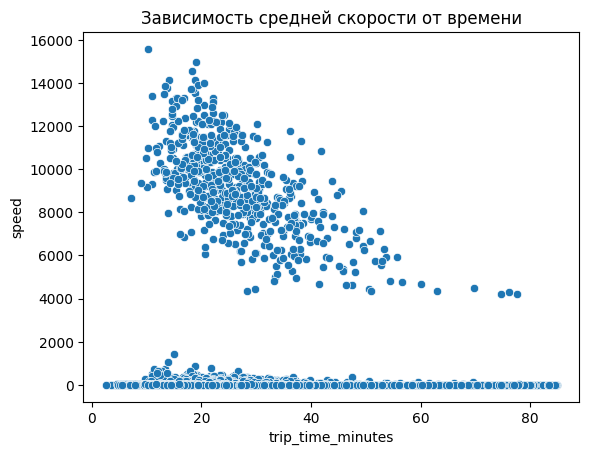

In [36]:
# посмотрим распределение скорости в зависимости от продолжительности поездки
sns.scatterplot(x=rides["trip_time_minutes"], y=rides["speed"])
plt.title('Зависимость средней скорости от времени')

In [37]:
# видим неадекватно большие скорости, посмотрим на эти значения подробнее
strange_speed = rides[rides["speed"] > 2000]

strange_speed.head(20)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
128,100461,2023-04-22 12:40:47,2023-04-22 13:10:45,Спортивная,Октябрьский,Свободы,Ленинский,4416111.0,0,2023-04-22 12:00:00,1798.0,8842.046496,29.97
135,100467,2023-04-22 12:49:51,2023-04-22 13:39:18,Полевая,Ленинский,Пионерская,Заречный,6627165.0,0,2023-04-22 12:00:00,2967.0,8041.049545,49.45
608,100917,2023-04-22 19:00:13,2023-04-22 19:26:39,Новая,Северо-западный,Мичурина,Ленинский,5146292.0,0,2023-04-22 19:00:00,1586.0,11681.368979,26.43
860,101154,2023-04-22 21:23:25,2023-04-22 21:41:45,Совхозная,Центральный,Речная,Юго-восточный,2992725.0,0,2023-04-22 21:00:00,1100.0,9794.372727,18.33
1012,101299,2023-04-22 23:54:39,2023-04-23 00:23:58,Дачная,Центральный,Свободы,Ленинский,4273850.0,0,2023-04-22 23:00:00,1759.0,8746.935759,29.32
1200,101477,2023-04-23 11:34:58,2023-04-23 11:55:20,Нагорная,Центральный,Труда,Центральный,2963346.0,0,2023-04-23 11:00:00,1222.0,8729.988216,20.37
1276,101550,2023-04-23 13:16:11,2023-04-23 13:32:50,Спортивная,Октябрьский,Луговая,Октябрьский,3082585.0,0,2023-04-23 13:00:00,999.0,11108.414414,16.65
1471,101735,2023-04-23 16:13:49,2023-04-23 16:48:48,Гагарина,Центральный,Сосновая,Юго-восточный,4121025.0,0,2023-04-23 16:00:00,2099.0,7067.979990,34.98
1679,101931,2023-04-23 18:42:02,2023-04-23 19:13:32,Овражная,Центральный,Школьная,Северо-западный,5351021.0,0,2023-04-23 18:00:00,1890.0,10192.420952,31.50
1705,101956,2023-04-23 19:05:33,2023-04-23 19:29:14,Буденного,Октябрьский,Комсомольская,Заречный,3272216.0,0,2023-04-23 19:00:00,1421.0,8289.920901,23.68


In [38]:
strange_speed.describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,593.000000,593,593,5.930000e+02,593.000000,593,593.000000,593.000000,593.000000
mean,148492.195616,2023-06-13 08:21:36.035413248,2023-06-13 08:48:03.386171904,3.828249e+06,0.021922,2023-06-13 07:51:54.333895424,1587.350759,9202.813447,26.455767
min,100461.000000,2023-04-22 12:40:47,2023-04-22 13:10:45,1.019979e+06,0.000000,2023-04-22 12:00:00,425.000000,4210.304471,7.080000
25%,125157.000000,2023-05-21 13:48:09,2023-05-21 14:36:20,3.127067e+06,0.000000,2023-05-21 13:00:00,1166.000000,7910.943861,19.430000
50%,148817.000000,2023-06-14 09:09:57,2023-06-14 10:26:04,3.730580e+06,0.000000,2023-06-14 09:00:00,1463.000000,9264.407895,24.380000
75%,173338.000000,2023-07-08 19:33:39,2023-07-08 19:59:17,4.472071e+06,0.000000,2023-07-08 19:00:00,1862.000000,10518.117293,31.030000
max,197668.000000,2023-07-31 22:08:56,2023-07-31 22:22:34,7.569789e+06,1.000000,2023-07-31 22:00:00,4652.000000,15580.652700,77.530000
std,27745.226420,NaN,NaN,9.914766e+05,0.146554,NaN,608.014648,2056.547545,10.133529


Text(0.5, 1.0, 'Зависимость средней скорости от времени')

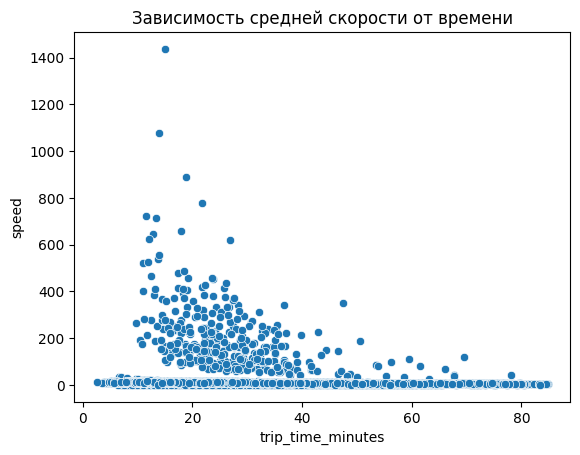

In [39]:
# заметим, что значения пройденного расстояния слишком большие, это может быть связано с ошибкой при сборе данных
# посмотрим на данные без них
sns.scatterplot(x=rides["trip_time_minutes"], y=rides[rides["speed"] < 2000]["speed"])
plt.title('Зависимость средней скорости от времени')

In [40]:
# есть группа со значениями все еще далекими от реальности, но уже не такимими заоблачными
# рассмотрим их

strange_mean_speed = rides[(rides["speed"] > 25) & (rides["speed"] < 2000)]
strange_mean_speed.head(20)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
637,100944,2023-04-22 19:18:20,2023-04-22 19:54:54,Пролетарская,Центральный,Заречная,Юго-восточный,57518.000000,0,2023-04-22 19:00:00,2194.0,94.377758,36.57
866,101160,2023-04-22 21:26:18,2023-04-22 21:46:33,Дачная,Центральный,Комсомольская,Заречный,34414.173469,0,2023-04-22 21:00:00,1215.0,101.967921,20.25
995,101283,2023-04-22 23:28:55,2023-04-23 00:15:28,Совхозная,Центральный,Чапаева,Северо-западный,110514.475000,0,2023-04-22 23:00:00,2793.0,142.446155,46.55
1193,101470,2023-04-23 11:26:28,2023-04-23 12:10:50,Речная,Юго-восточный,Пионерская,Заречный,109222.892857,0,2023-04-23 11:00:00,2662.0,147.709397,44.37
1714,101964,2023-04-23 19:14:28,2023-04-23 19:49:37,Куйбышева,Центральный,Красноармейская,Юго-восточный,133588.031250,0,2023-04-23 19:00:00,2109.0,228.030779,35.15
1726,101973,2023-04-23 19:21:12,2023-04-23 19:47:33,Мира,Центральный,Цветочная,Северо-западный,133588.031250,0,2023-04-23 19:00:00,1581.0,304.185270,26.35
2400,102613,2023-04-24 17:33:51,2023-04-24 17:57:42,Школьная,Северо-западный,Майская,Октябрьский,31185.922222,0,2023-04-24 17:00:00,1431.0,78.455150,23.85
2402,102615,2023-04-24 17:36:34,2023-04-24 17:59:53,Первомайская,Северо-западный,Строительная,Северо-западный,31185.922222,0,2023-04-24 17:00:00,1399.0,80.249693,23.32
2601,102807,2023-04-24 20:28:48,2023-04-24 21:00:00,Парковая,Юго-восточный,Комсомольская,Заречный,91856.255319,0,2023-04-24 20:00:00,1872.0,176.646645,31.20
2883,103078,2023-04-25 11:46:24,2023-04-25 12:10:07,Гагарина,Центральный,Чехова,Заречный,149788.809524,0,2023-04-25 11:00:00,1423.0,378.945688,23.72


In [41]:
strange_mean_speed.describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,353.000000,353,353,353.000000,353.000000,353,353.000000,353.000000,353.000000
mean,151598.300283,2023-06-16 10:11:11.356940288,2023-06-16 10:38:03.586402304,76979.025206,0.008499,2023-06-16 09:41:18.186968832,1612.229462,196.490592,26.870453
min,100944.000000,2023-04-22 19:18:20,2023-04-22 19:54:54,3680.111111,0.000000,2023-04-22 19:00:00,397.000000,27.716318,6.620000
25%,127070.000000,2023-05-23 09:55:35,2023-05-23 10:24:05,41673.669643,0.000000,2023-05-23 09:00:00,1168.000000,98.751138,19.470000
50%,153147.000000,2023-06-18 14:30:13,2023-06-18 15:06:14,63689.816901,0.000000,2023-06-18 14:00:00,1528.000000,155.099996,25.470000
75%,178146.000000,2023-07-13 14:21:19,2023-07-13 14:39:47,96754.464286,0.000000,2023-07-13 14:00:00,1910.000000,244.494125,31.830000
max,197544.000000,2023-07-31 20:27:55,2023-07-31 20:58:11,358140.823529,1.000000,2023-07-31 20:00:00,4681.000000,1437.354476,78.020000
std,28825.874853,NaN,NaN,48242.411542,0.091925,NaN,645.962004,156.209674,10.766026


Text(0.5, 1.0, 'Зависимость средней скорости от времени')

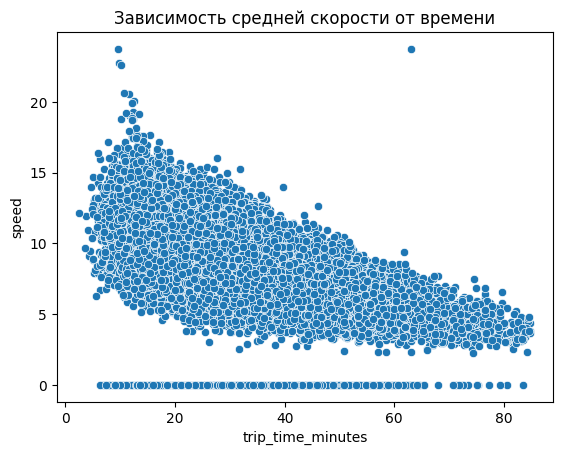

In [42]:
# посмотрим данные без них
# нижняя граница 25 км\ч, так как максимальная разрешенная скорость езды в городе, но я допускаю, что есть нарушители
# этот параметр можно варьиовать в зависимости от задачи, которую мы решаем
# к примеру, если бы мы хотели повысить безопасноть и снизить правонарушения, то смотрели бы на большую скорость
sns.scatterplot(x=rides["trip_time_minutes"], y=rides[(rides["speed"] < 25)]['speed'])
plt.title('Зависимость средней скорости от времени')

In [43]:
# есть значения со скоростью близкой к 0, посмотрим на них
strange_small_speed = rides[rides["speed"] < 1]
strange_small_speed.head(20)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-восточный,3.0,0,2023-04-22 09:00:00,1042.0,0.010365,17.37
21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,Лермонтова,Ленинский,Дружбы,Центральный,5.0,0,2023-04-22 10:00:00,1766.0,0.010193,29.43
67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,Ленина,Ленинский,Овражная,Центральный,5.0,0,2023-04-22 11:00:00,3133.0,0.005745,52.22
70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,Строительная,Северо-западный,Строительная,Северо-западный,4.0,0,2023-04-22 11:00:00,1074.0,0.013408,17.90
108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,Заводская,Северо-западный,Свердлова,Центральный,4.0,0,2023-04-22 12:00:00,2008.0,0.007171,33.47
144,100476,2023-04-22 12:57:54,2023-04-22 13:35:15,Березовая,Северо-западный,Майская,Октябрьский,4.0,0,2023-04-22 12:00:00,2241.0,0.006426,37.35
189,100518,2023-04-22 13:54:36,2023-04-22 14:36:59,Луговая,Октябрьский,Труда,Центральный,4.0,0,2023-04-22 13:00:00,2543.0,0.005663,42.38
221,100549,2023-04-22 14:19:42,2023-04-22 14:43:20,Дзержинского,Центральный,Восточная,Октябрьский,4.0,0,2023-04-22 14:00:00,1418.0,0.010155,23.63
222,100550,2023-04-22 14:19:55,2023-04-22 14:40:40,Западная,Ленинский,Маяковского,Центральный,3.0,0,2023-04-22 14:00:00,1245.0,0.008675,20.75
246,100573,2023-04-22 14:41:28,2023-04-22 14:59:45,Центральная,Юго-восточный,Сиреневая,Юго-восточный,3.0,0,2023-04-22 14:00:00,1097.0,0.009845,18.28


In [44]:
strange_small_speed.describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,2939.000000,2939,2939,2939.000000,2939.000000,2939,2939.000000,2939.000000,2939.000000
mean,148851.025179,2023-06-13 17:11:58.232731904,2023-06-13 17:38:17.505614336,3.814223,0.018033,2023-06-13 16:41:24.110241792,1579.272882,0.009194,26.321204
min,100348.000000,2023-04-22 09:21:42,2023-04-22 09:39:04,1.000000,0.000000,2023-04-22 09:00:00,383.000000,0.002395,6.380000
25%,124771.500000,2023-05-20 22:42:20.500000,2023-05-20 23:13:22,3.000000,0.000000,2023-05-20 22:00:00,1177.500000,0.007684,19.625000
50%,148519.000000,2023-06-13 20:14:47,2023-06-13 20:53:43,4.000000,0.000000,2023-06-13 20:00:00,1473.000000,0.009106,24.550000
75%,173634.000000,2023-07-08 22:44:32,2023-07-08 23:16:19.500000,4.000000,0.000000,2023-07-08 22:30:00,1851.500000,0.010693,30.860000
max,197693.000000,2023-07-31 23:10:07,2023-07-31 23:23:49,8.000000,1.000000,2023-07-31 23:00:00,5006.000000,0.018305,83.430000
std,28007.995334,NaN,NaN,1.033570,0.133095,NaN,591.598487,0.002189,9.860044


In [45]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 102254
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  97372 non-null  int64         
 1   start_date          97372 non-null  datetime64[ns]
 2   end_date            97372 non-null  datetime64[ns]
 3   start_location      97372 non-null  object        
 4   start_district      97372 non-null  object        
 5   end_location        97372 non-null  object        
 6   end_district        97372 non-null  object        
 7   distance            97372 non-null  float64       
 8   promo               97372 non-null  int64         
 9   rounded_start_date  97372 non-null  datetime64[ns]
 10  trip_time_seconds   97372 non-null  float64       
 11  speed               97372 non-null  float64       
 12  trip_time_minutes   97372 non-null  float64       
dtypes: datetime64[ns](3), float64(4), int64(2), object

### заменяем выбросы

In [46]:
# данные делятся на 4 группы: с очень выскокой, высокой, низкрой с редней скоростью
# больше всего нам важен сам факт того, что поездка состоялась, поэтому не будем удалять выбросы
# природа выбросов - неправильная запись данных, а в частности, расстояния поездки
# заменим их дистанции на основе поездок из сегмента по скорости от 1 до 25 км/ч так:
# ищем все поездки, где совпадают начало и конец (либо конец и начало) с значениями в пропусках и берем среднее расстояние
# еще можно наложить фильтр по времени суток поездки, заполнять средним по ближайшим поездкам в данной локации
# с или без учета конечного пункта
# учитывать продолжительность поездки и тд, но я думаю, что это излишне
def correct_speed(data):
    start = data['start_date']
    end = data['end_date']

    start = pd.to_datetime(start)  # Преобразуем 'start' в формат datetime
    pre_frame = rides.loc[(rides['speed'] > 0.6) & (rides['speed'] < 25) &
                          (((rides.start_location == data.start_location) & (rides.end_location == data.end_location)) |
                           ((rides.start_location == data.end_location) & (rides.end_location == data.start_location))),
    'distance'].mean()

    return pre_frame


# Заменяем значения расстояний на соответствующие значения из grouped_data
rides.loc[(rides['speed'] < 0.6) | (rides['speed'] > 25), 'distance'] = rides.loc[
    (rides['speed'] < 0.6) | (rides['speed'] > 25)].apply(correct_speed, axis=1)

# пересчитываем скорость
rides['speed'] = (rides['distance'] / 1000) / (rides['trip_time_seconds'] / 3600)




In [47]:
rides.describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,97372.000000,97372,97372,97372.000000,97372.000000,97372,97372.000000,97372.000000,97372.000000
mean,149025.500000,2023-06-13 21:06:08.931407360,2023-06-13 21:32:31.446267904,3819.756370,0.019626,2023-06-13 20:36:18.885100544,1582.514861,9.211485,26.375252
min,100340.000000,2023-04-22 09:01:03,2023-04-22 09:24:45,519.000000,0.000000,2023-04-22 09:00:00,154.000000,2.279973,2.570000
25%,124682.750000,2023-05-20 21:41:39.500000,2023-05-20 22:07:33.750000128,3131.000000,0.000000,2023-05-20 21:00:00,1170.000000,7.784834,19.500000
50%,149025.500000,2023-06-14 15:15:46,2023-06-14 15:44:53,3735.875376,0.000000,2023-06-14 15:00:00,1478.000000,9.178378,24.630000
75%,173368.250000,2023-07-08 19:50:22.249999872,2023-07-08 20:18:30,4412.000000,0.000000,2023-07-08 19:00:00,1872.000000,10.580988,31.200000
max,197711.000000,2023-07-31 23:57:01,2023-08-01 00:42:12,24993.307692,1.000000,2023-07-31 23:00:00,5090.000000,41.960964,84.830000
std,28109.019543,NaN,NaN,1004.888842,0.138711,NaN,596.046183,2.131598,9.934108


In [48]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 102254
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  97372 non-null  int64         
 1   start_date          97372 non-null  datetime64[ns]
 2   end_date            97372 non-null  datetime64[ns]
 3   start_location      97372 non-null  object        
 4   start_district      97372 non-null  object        
 5   end_location        97372 non-null  object        
 6   end_district        97372 non-null  object        
 7   distance            97372 non-null  float64       
 8   promo               97372 non-null  int64         
 9   rounded_start_date  97372 non-null  datetime64[ns]
 10  trip_time_seconds   97372 non-null  float64       
 11  speed               97372 non-null  float64       
 12  trip_time_minutes   97372 non-null  float64       
dtypes: datetime64[ns](3), float64(4), int64(2), object

Text(0.5, 1.0, 'Зависимость средней скорости от времени')

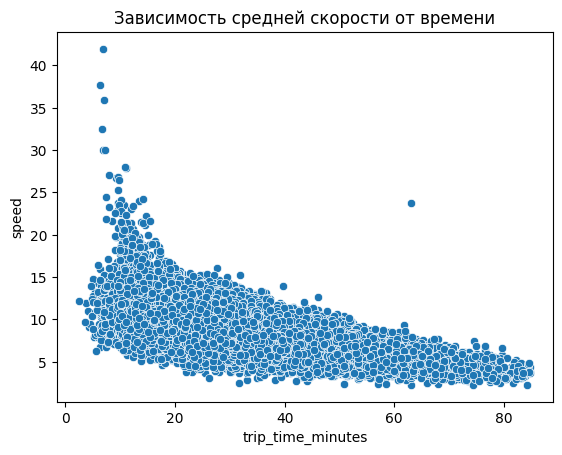

In [49]:
sns.scatterplot(x=rides["trip_time_minutes"], y=rides["speed"])
plt.title('Зависимость средней скорости от времени')

<Axes: ylabel='speed'>

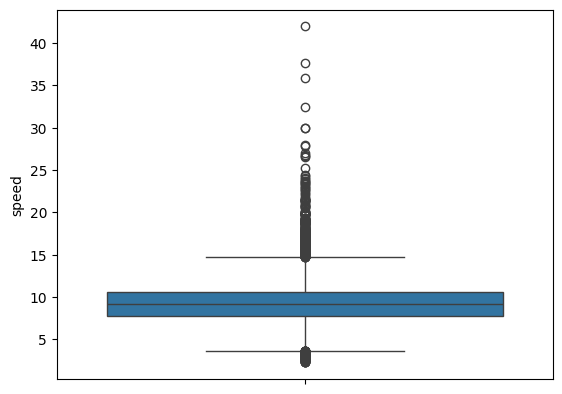

In [50]:
sns.boxplot(y=rides["speed"])

In [51]:
rides.describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,97372.000000,97372,97372,97372.000000,97372.000000,97372,97372.000000,97372.000000,97372.000000
mean,149025.500000,2023-06-13 21:06:08.931407360,2023-06-13 21:32:31.446267904,3819.756370,0.019626,2023-06-13 20:36:18.885100544,1582.514861,9.211485,26.375252
min,100340.000000,2023-04-22 09:01:03,2023-04-22 09:24:45,519.000000,0.000000,2023-04-22 09:00:00,154.000000,2.279973,2.570000
25%,124682.750000,2023-05-20 21:41:39.500000,2023-05-20 22:07:33.750000128,3131.000000,0.000000,2023-05-20 21:00:00,1170.000000,7.784834,19.500000
50%,149025.500000,2023-06-14 15:15:46,2023-06-14 15:44:53,3735.875376,0.000000,2023-06-14 15:00:00,1478.000000,9.178378,24.630000
75%,173368.250000,2023-07-08 19:50:22.249999872,2023-07-08 20:18:30,4412.000000,0.000000,2023-07-08 19:00:00,1872.000000,10.580988,31.200000
max,197711.000000,2023-07-31 23:57:01,2023-08-01 00:42:12,24993.307692,1.000000,2023-07-31 23:00:00,5090.000000,41.960964,84.830000
std,28109.019543,NaN,NaN,1004.888842,0.138711,NaN,596.046183,2.131598,9.934108


In [52]:
rides["speed"].isna().sum()

0

In [53]:
# видим, что естть несколько отрывающихся точек со скоростью больше 25 км/ч
# рассмотрим их
rides[rides["speed"] > 25]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
10030,109879,2023-05-03 15:53:23,2023-05-03 16:04:24,Полевая,Ленинский,Чехова,Заречный,5117.115385,0,2023-05-03 15:00:00,661.0,27.869312,11.02
11233,111029,2023-05-04 21:24:40,2023-05-04 21:33:56,Парковая,Юго-восточный,Набережная,Центральный,4114.769231,0,2023-05-04 21:00:00,556.0,26.642391,9.27
18133,117607,2023-05-12 17:49:31,2023-05-12 17:56:08,Пионерская,Заречный,Ломоносова,Октябрьский,3583.011075,0,2023-05-12 17:00:00,397.0,32.490781,6.62
34185,132898,2023-05-29 08:33:53,2023-05-29 08:40:48,Новая,Северо-западный,Заречная,Юго-восточный,4837.166667,1,2023-05-29 08:00:00,415.0,41.960964,6.92
37374,135923,2023-06-01 19:56:53,2023-06-01 20:07:50,Речная,Юго-восточный,Школьная,Северо-западный,5101.045455,0,2023-06-01 19:00:00,657.0,27.950934,10.95
37376,135925,2023-06-01 19:59:05,2023-06-01 20:06:10,Трудовая,Центральный,Строительная,Северо-западный,4233.722222,0,2023-06-01 19:00:00,425.0,35.862118,7.08
37584,136124,2023-06-02 05:27:38,2023-06-02 05:37:19,Северная,Центральный,Речная,Юго-восточный,4325.538462,0,2023-06-02 05:00:00,581.0,26.801959,9.68
37645,136183,2023-06-02 07:25:32,2023-06-02 07:32:25,Луговая,Октябрьский,Вишневая,Юго-восточный,3438.042553,0,2023-06-02 07:00:00,413.0,29.968410,6.88
38250,136763,2023-06-02 18:57:42,2023-06-02 19:04:51,Заводская,Северо-западный,Полевая,Ленинский,3575.666667,0,2023-06-02 18:00:00,429.0,30.005594,7.15
48067,146114,2023-06-11 15:56:12,2023-06-11 16:05:50,Пионерская,Заречный,Северная,Центральный,4052.742857,0,2023-06-11 15:00:00,578.0,25.241997,9.63


In [54]:
rides[rides["speed"] > 25].describe()

,id,start_date,end_date,distance,promo,rounded_start_date,trip_time_seconds,speed,trip_time_minutes
count,13.000000,13,13,13.000000,13.000000,13,13.000000,13.000000,13.000000
mean,137040.384615,2023-06-02 04:42:24.692307712,2023-06-02 04:50:49.538461696,4178.109933,0.076923,2023-06-02 04:00:00,504.846154,30.458115,8.413846
min,109879.000000,2023-05-03 15:53:23,2023-05-03 16:04:24,3438.042553,0.000000,2023-05-03 15:00:00,383.000000,25.241997,6.380000
25%,132898.000000,2023-05-29 08:33:53,2023-05-29 08:40:48,3626.193548,0.000000,2023-05-29 08:00:00,415.000000,26.801959,6.920000
50%,136124.000000,2023-06-02 05:27:38,2023-06-02 05:37:19,4114.769231,0.000000,2023-06-02 05:00:00,483.000000,27.950934,8.050000
75%,146114.000000,2023-06-11 15:56:12,2023-06-11 16:05:50,4325.538462,0.000000,2023-06-11 15:00:00,581.000000,32.490781,9.680000
max,176489.000000,2023-07-11 15:54:13,2023-07-11 16:03:58,5117.115385,1.000000,2023-07-11 15:00:00,661.000000,41.960964,11.020000
std,18370.746453,NaN,NaN,564.888309,0.277350,NaN,101.372947,5.107104,1.689973


данные со скоростью больше 25 км\ч остались, при проверке гипотез мы не будем их учитывать. Но они позволяют нам увидеть тренд, что средняя скорость меньше при большей времени поездки, что тоже немаловажно. Если 1 значение со скоростью примерно 23 км\ч и длительностью около часа. Там человек проехал около 23 км, поэтому это валидная ситуация, может быть он ехал почти без пробок или по прямой


Теперь значения в таблице rides примерно адекватные

### корректируем таблицу weather


In [55]:
# посмотрим количество пропусков в погоде
weather.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

In [56]:
# заполняем пропуски в температуре в weather
# путем вычисления среднего между ближайшими существующими значениями за 24 часа до и после пропущенного значения.
def temperature_nan():
    sp_ind = []
    for i, a in enumerate(weather["temperature"]):
        if "nan" in str(a):
            sp_ind.append(i)

    res = []
    a = sp[0]

    k = 1
    for i in range(1, len(sp_ind)):
        if a + k != sp_ind[i]:
            k = 0
            res.append((a, sp_ind[i - 1]))
            a = sp_ind[i]
        k += 1

    for i in sp_ind:
        sp[i] = (sp[i - 24] + sp[i + 24]) / 2


sp = weather["temperature"].astype(np.float32).to_list()
temperature_nan()

weather["temperature"] = sp
weather["temperature"] = weather["temperature"].astype(np.float32)

# Остальные nan значения в weather меняем с помощью интреполяции
# Подразумевается, что значения меняются примерно линейно между точками данных.
for i in weather.columns[2:]:
    weather[i] = weather[i].interpolate(method='linear')

In [57]:
weather.isna().sum()

datetime               0
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64

# Рассчеты и исследования

In [58]:
# Объединение таблиц по округленной дате
merged = pd.merge(rides, weather, left_on='rounded_start_date', right_on='datetime', how='inner')

# Удаление столбца который нам уже не понадобится
merged = merged.drop(['rounded_start_date'], axis=1)

merged.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,trip_time_seconds,speed,trip_time_minutes,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-восточный,Майская,Октябрьский,4069.000000,0,1422.0,10.301266,23.70,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.000000,0,1705.0,9.533138,28.42,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.000000,0,2299.0,7.077860,38.32,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-западный,3881.000000,0,1909.0,7.318806,31.82,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-западный,Юбилейная,Юго-восточный,4029.000000,0,1840.0,7.882826,30.67,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-восточный,Западная,Ленинский,4879.000000,0,2387.0,7.358358,39.78,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.000000,0,649.0,10.239753,10.82,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.000000,0,1250.0,9.023040,20.83,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-восточный,4015.882353,0,1042.0,13.874450,17.37,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-восточный,5263.000000,0,2048.0,9.251367,34.13,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696


In [59]:
len(merged)

97372

In [60]:
# разбиваем по времени суток для рассчета стоимости поездки
def time_of_day(date):
    if 1 <= datetime.time(date).hour < 6:
        return 'глубокая ночь'
    elif datetime.time(date).hour < 10:
        return 'утро'
    elif datetime.time(date).hour < 16:
        return 'день'
    elif datetime.time(date).hour < 22:
        return 'вечер'
    else:
        return 'ранняя ночь'


# Создайм категориальный столбец со временем суток
merged['times_of_day'] = merged['datetime'].apply(time_of_day)
merged.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,trip_time_seconds,speed,trip_time_minutes,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,times_of_day
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-восточный,Майская,Октябрьский,4069.000000,0,1422.0,10.301266,23.70,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.000000,0,1705.0,9.533138,28.42,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.000000,0,2299.0,7.077860,38.32,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-западный,3881.000000,0,1909.0,7.318806,31.82,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-западный,Юбилейная,Юго-восточный,4029.000000,0,1840.0,7.882826,30.67,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-восточный,Западная,Ленинский,4879.000000,0,2387.0,7.358358,39.78,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.000000,0,649.0,10.239753,10.82,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.000000,0,1250.0,9.023040,20.83,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-восточный,4015.882353,0,1042.0,13.874450,17.37,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-восточный,5263.000000,0,2048.0,9.251367,34.13,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро


In [61]:
def money(info):
    time = info['times_of_day']
    weekday = datetime.date(info['start_date']).isoweekday()
    promo = info['promo']
    discount = 0
    # Расчитываем коэффициент по тарифу
    if time == 'глубокая ночь':
        coeff = 3
    elif time == 'утро':
        coeff = 4
        if weekday == 1 and promo == 1:
            discount = 30
    elif time == 'день' or time == 'ранняя ночь':
        if weekday < 6:
            coeff = 5
        else:
            coeff = 6
    elif time == 'вечер':
        if weekday < 6:
            coeff = 6
        else:
            coeff = 7

    price = 30 - discount + info['trip_time_minutes'] * coeff
    return price


# Создаём столбец с ценой поездки
merged['price'] = merged[['start_date', 'trip_time_minutes', 'times_of_day', 'promo']].apply(money, axis=1)
merged['price'].head(10)

0    124.80
1    143.68
2    183.28
3    157.28
4    152.68
5    189.12
6     73.28
7    113.32
8     99.48
9    166.52
Name: price, dtype: float64

In [62]:
merged.duplicated().value_counts()

False    97372
Name: count, dtype: int64

In [63]:
# Удаляем явные дупликаты
merged = merged.drop_duplicates()
merged.shape

(97372, 21)

In [64]:
# Группируем данные по часам и локациям, считаем количество записей в каждой группе (спрос на локации по часу)
merged['hourly_count'] = merged.groupby([pd.DatetimeIndex(merged['datetime']),
                                         merged['start_location']])['datetime'].transform('count')


merged.head(15)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,trip_time_seconds,...,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,times_of_day,price,hourly_count
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-восточный,Майская,Октябрьский,4069.000000,0,1422.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,124.80,1
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.000000,0,1705.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,143.68,2
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.000000,0,2299.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,183.28,2
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-западный,3881.000000,0,1909.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,157.28,1
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-западный,Юбилейная,Юго-восточный,4029.000000,0,1840.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,152.68,1
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-восточный,Западная,Ленинский,4879.000000,0,2387.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,189.12,1
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.000000,0,649.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,73.28,1
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.000000,0,1250.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,113.32,1
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-восточный,4015.882353,0,1042.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,99.48,1
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-восточный,5263.000000,0,2048.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,166.52,1


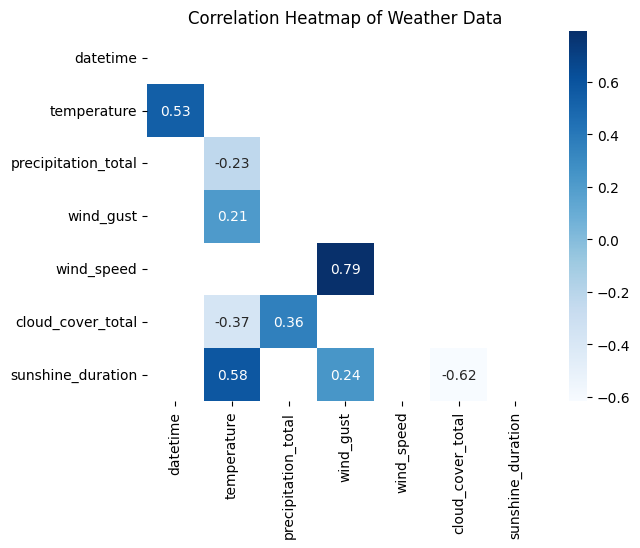

In [65]:
# Посмотрим корреляции
a = merged[['datetime',
'temperature', 'precipitation_total', 'wind_gust', 'wind_speed',
'cloud_cover_total', 'sunshine_duration']]

correl = a.corr(method='spearman')

# Создаем маску для верхнего треугольника
mask = np.triu(np.ones_like(correl, dtype=bool))

heatmap = sns.heatmap(correl[(correl >= 0.2) | (correl <= -0.2)], annot=True, fmt=".2f", cmap="Blues", mask=mask)
plt.title('Correlation Heatmap of Weather Data')
plt.show()

Сильная/средняя корреляция:
1. температура и длительность солнечной погоды
2. порывы и скорость ветра
3. длительность солнечной погоды и облачность
4. облачность и количество осадков
5. облачность и температура

Слабая кореляция:
1. осадки и температура
2. порывы ветра и температура
3. длительность солнечной погоды и порывы ветра

корреляции первого блока выглядат реалистично, потому что обычно в солнечную погоду теплее, меньше осадков и меньше облаков, чем в облачную погоду + обычно чем сильнее ветер тем сильнее его порывы


среди корреляций второго блока правдоподобно выглядит зависимость между осадками и температурой, потому что обычно когда есть осадки температура ниже + зависимость между температурой и порывами ветра, так как ветер образуется из=за перепадов давления (а где холодно - там низкое давление, где тепло - высокое)

а вот длительность солнечной погоды и порывы ветра менее очевидна. Так как температура коррелирует с солнечной погодой, а температура с порывами ветра такая связь может быть, но это нужно проверять


In [66]:
merged.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,trip_time_seconds,...,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,times_of_day,price,hourly_count
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-восточный,Майская,Октябрьский,4069.0,0,1422.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,124.80,1
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0,1705.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,143.68,2
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0,2299.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,183.28,2
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-западный,3881.0,0,1909.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,157.28,1
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-западный,Юбилейная,Юго-восточный,4029.0,0,1840.0,...,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,утро,152.68,1


In [67]:
# найдем максимальное значение спроса за кадлый час для каждой улицы - еоличество поездок, закончившихся в ней
# это необходимое количество самокатов утром

new = merged.copy()

# Подсчет количества поездок, начавшихся в каждой start_location
daily_loc_start = new.groupby(['start_location', 'datetime']).size().reset_index(name='dayly_loc_start')

# Подсчет количества поездок, закончившихся в каждой end_location
daily_loc_end = new.groupby(['end_location', 'datetime']).size().reset_index(name='dayly_loc_end')

# Объединение результатов по общему ключу start_location и datetime
daily_counts = daily_loc_start.merge(daily_loc_end, how='outer', left_on=['start_location', 'datetime'], right_on=['end_location', 'datetime'])

# Замена отсутствующих значений на 0
daily_counts.fillna(0, inplace=True)

# считаем разницу между прибывшими и убывшимыми
daily_counts['range'] = daily_counts['dayly_loc_end'] - daily_counts['dayly_loc_start']
daily_counts['range_max'] = daily_counts['range']
daily_counts['range_min'] = daily_counts['range']


# берем максимальное мо каждому значению
for_graf = daily_counts.groupby('start_location', as_index=False).agg({"range_max":'max', "range_min":'min',
                                                                       'dayly_loc_start':'max','dayly_loc_end':'max'})

for_graf

,start_location,range_max,range_min,dayly_loc_start,dayly_loc_end
0,0,9.0,1.0,0.0,9.0
1,Береговая,3.0,-5.0,5.0,4.0
2,Березовая,3.0,-5.0,5.0,5.0
3,Буденного,5.0,-6.0,9.0,7.0
4,Вишневая,3.0,-4.0,4.0,4.0
...,...,...,...,...,...
87,Шоссейная,4.0,-7.0,8.0,5.0
88,Энергетиков,3.0,-4.0,5.0,4.0
89,Энтузиастов,2.0,-5.0,5.0,3.0
90,Юбилейная,4.0,-4.0,4.0,5.0


Text(0.5, 0, 'Штук')

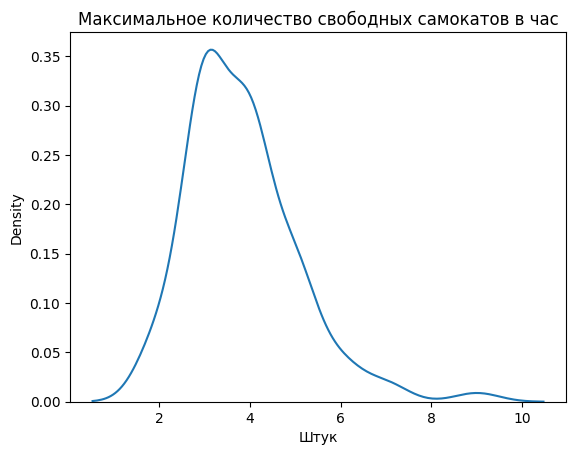

In [68]:
sns.kdeplot(for_graf['range_max'])

plt.title('Максимальное количество свободных самокатов в час')
plt.xlabel('Штук')

Text(0.5, 0, 'Штук')

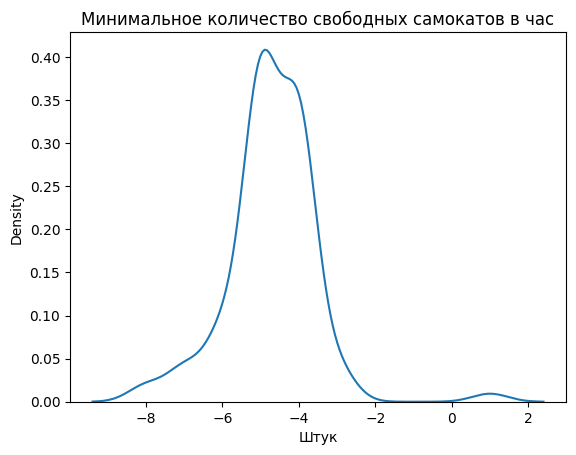

In [69]:
sns.kdeplot(for_graf['range_min'])

plt.title('Минимальное количество свободных самокатов в час')
plt.xlabel('Штук')

Итого имеем таблицу, где для кажджой точки посчитано минимальный и максимальный дефицит/профицит самокатов

In [70]:
import pandas as pd

# Округляем datetime до дня
new['day'] = new['datetime'].dt.floor('d')

# Группируем по местоположению и дню и суммируем спрос
mas = new.groupby(['start_location', 'day'], as_index=False)['hourly_count'].sum()

# Вычисляем средний спрос по всем дням
mas = mas.groupby('start_location', as_index=False)['hourly_count'].mean().sort_values('hourly_count')


In [71]:
# топ 3 точки с самым низким спросом
mas.head(3)

,start_location,hourly_count
39,Мира,11.851485
67,Сиреневая,12.089109
89,Юбилейная,12.247525


In [72]:
# топ 3 точки с самым высоким спросом
mas.tail(3)

,start_location,hourly_count
36,Майская,55.069307
35,Луговая,56.544554
34,Ломоносова,58.386139


Text(0, 0.5, 'Дневной спрос')

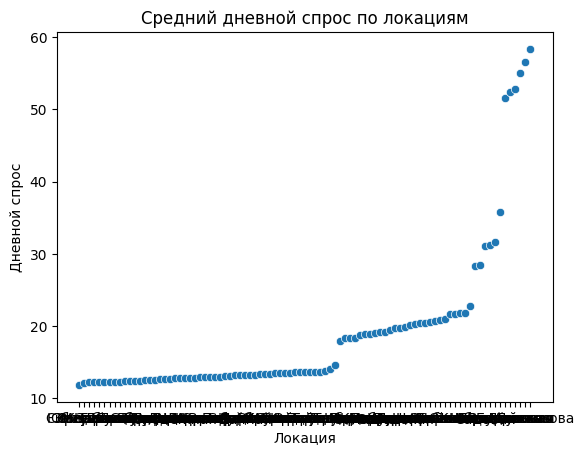

In [73]:
# график нужен чисто для презы и понимания общей картины, чтобы посмотреть на данные
sns.scatterplot(mas, y='hourly_count', x='start_location')
plt.title('Средний дневной спрос по локациям')
plt.xlabel('Локация')
plt.ylabel('Дневной спрос')

In [74]:
val = mas.loc[mas['hourly_count'] < 15, 'hourly_count'].sum() / mas['hourly_count'].sum()

print('Доля в общем спросе точкек со спросом меньше 15:', f'{round(val * 100)}%')

Доля в общем спросе точкек со спросом меньше 15: 39%


In [75]:
val = mas.loc[mas['hourly_count'] < 15, 'hourly_count'].count() / len(mas['hourly_count'])

print('Доля в общем количестве точкек со спросом меньше 15:', f'{round(val * 100)}%')

Доля в общем количестве точкек со спросом меньше 15: 57%


In [76]:
#посмотрим на самые частые направления движения
grouped_df = merged.groupby(['start_location', 'end_location'], as_index=False).size().sort_values('size')


# топ самых частых напривлений движения по точкам
print(grouped_df.tail(10))


     start_location end_location  size
3219        Луговая      Луговая    57
6555     Спортивная    Восточная    58
3165     Ломоносова   Спортивная    58
3277        Майская    Буденного    58
490       Восточная      Луговая    58
489       Восточная   Ломоносова    59
6586     Спортивная      Майская    60
3347        Майская   Спортивная    61
3256        Луговая   Спортивная    67
184       Буденного    Буденного    68


In [77]:
grouped_df = merged.groupby(['start_district', 'end_district'], as_index=False).size().sort_values('size')


# топ самых частых напривлений движения по районам
print(grouped_df.tail(10))

     start_district     end_district  size
16      Октябрьский      Центральный  3424
35    Юго-восточный    Юго-восточный  3593
26      Центральный      Октябрьский  3633
10        Ленинский      Центральный  3922
25      Центральный        Ленинский  3948
22  Северо-западный      Центральный  3988
27      Центральный  Северо-западный  4175
34    Юго-восточный      Центральный  4663
29      Центральный    Юго-восточный  4946
28      Центральный      Центральный  6035


### Вывод: рекомендую закрыть точки в улицах со средним спросом меньше 15, так как на них уходит больше половины затрат на содержание (их 57% от общего количества точек), а дохода они приносят примерно 39% от общего. Заметим, что в самых частых направлениях пути идут в обще стороны. То есть происходит саморегуляия самокатов по точкам. Вероятно, это связано с тем, что кто приехал тот уехал, а значит и привез самокат на место. Однако бывадют часы, когда дефицит самокатов около 8 штук (уехало юольше, чем приехало), поэтому на некоторых точках необходимо перераспределение, чтобы поддерживать равновесие

В перспективе это можно проверить статистически но я устал

## Промокоды

Так как понедельник и вторник примерно одинаковые дни недели, будем сравнивать именно эти 2 дня

In [111]:
merged['day_of_week'] = merged['datetime'].map(lambda x: x.isoweekday())

merged['day_of_week'].unique()

array([6, 7, 1, 2, 3, 4, 5])

In [113]:
monday = merged.loc[(merged['day_of_week'] == 1) & (merged['datetime'].dt.hour.between(6, 10))]
#
tuesday = merged.loc[(merged['day_of_week'] == 2) & (merged['datetime'].dt.hour.between(6, 10))]

In [114]:
monday.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,trip_time_seconds,...,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,times_of_day,price,hourly_count,day_of_week
1946,102286,2023-04-24 06:05:50,2023-04-24 06:22:30,Коммунальная,Юго-восточный,Ломоносова,Октябрьский,3031.0,0,1000.0,...,9.960245,0.0,37.079998,15.716793,46.0,32.121212,утро,96.68,1,1
1947,102287,2023-04-24 06:08:30,2023-04-24 06:31:30,Дорожная,Юго-восточный,Юбилейная,Юго-восточный,3151.0,1,1380.0,...,9.960245,0.0,37.079998,15.716793,46.0,32.121212,утро,92.00,2,1
1948,102288,2023-04-24 06:10:41,2023-04-24 06:40:40,Кирова,Ленинский,Рабочая,Северо-западный,4088.0,0,1799.0,...,9.960245,0.0,37.079998,15.716793,46.0,32.121212,утро,149.92,1,1
1949,102289,2023-04-24 06:12:32,2023-04-24 06:31:46,Полевая,Ленинский,Парковая,Юго-восточный,3664.0,0,1154.0,...,9.960245,0.0,37.079998,15.716793,46.0,32.121212,утро,106.92,5,1
1950,102290,2023-04-24 06:13:36,2023-04-24 06:26:49,Полевая,Ленинский,Дорожная,Юго-восточный,2476.0,1,793.0,...,9.960245,0.0,37.079998,15.716793,46.0,32.121212,утро,52.88,5,1


<Axes: ylabel='price'>

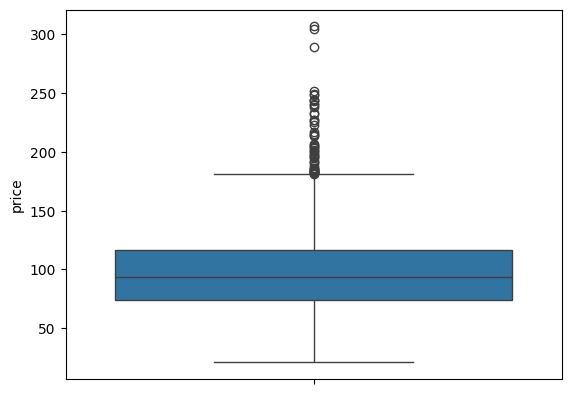

In [115]:
sns.boxplot(monday.loc[(monday['promo'] == 1), 'price'])


<Axes: ylabel='price'>

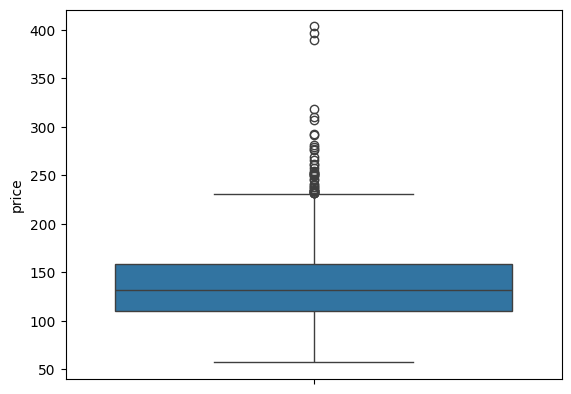

In [116]:
sns.boxplot(monday.loc[(monday['promo'] == 0), 'price'])

<ipython-input-152-456abaffd667>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_and_hour', y='avg_daily_demand', data=daily_demand, palette='Blues')


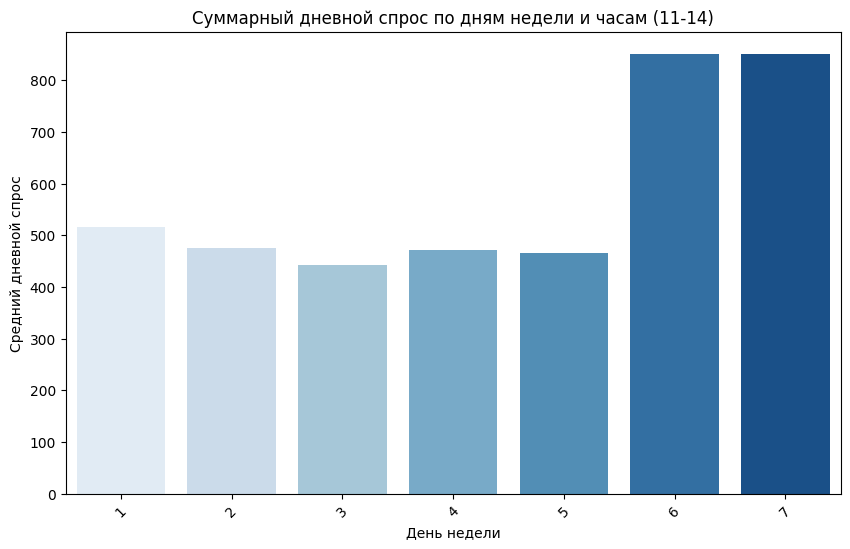

In [152]:
# 1) Вывожу в барплоте средний суммарный спрос по часам по дням недели с 10 до 14

# Создаем маску для фильтрации данных по часам с 11 до 14 включительно
mask = (merged['datetime'].dt.hour >= 11) & (merged['datetime'].dt.hour <= 14)

# Группируем данные по дням недели и часам, считаем количество строк
daily_demand = merged[mask].groupby([merged['day_of_week'], merged['datetime'].dt.hour])['price'].count().reset_index()
daily_demand.columns = ['day_of_week', 'hour', 'count']  # Переименовываем столбцы

# Вычисляем средний дневной спрос для каждого дня недели
daily_demand = daily_demand.groupby('day_of_week')['count'].mean().reset_index()
daily_demand.columns = ['day_and_hour', 'avg_daily_demand']  # Переименовываем столбцы

# Строим барплот
plt.figure(figsize=(10, 6))
sns.barplot(x='day_and_hour', y='avg_daily_demand', data=daily_demand, palette='Blues')
plt.title('Суммарный дневной спрос по дням недели и часам (11-14)')
plt.xlabel('День недели')
plt.ylabel('Средний дневной спрос')
plt.xticks(rotation=45)
plt.show()

In [121]:
# 2) Считаю в понедельник 30*количество типов с промокодами
monday_promo = merged.loc[(merged['day_of_week'] == 1) & (merged['promo'] == 1), 'price'].count() * 30
monday_promo

57330

<ipython-input-153-8de41e90a540>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='datetime', y='price', data=morning_trips, palette='Blues')


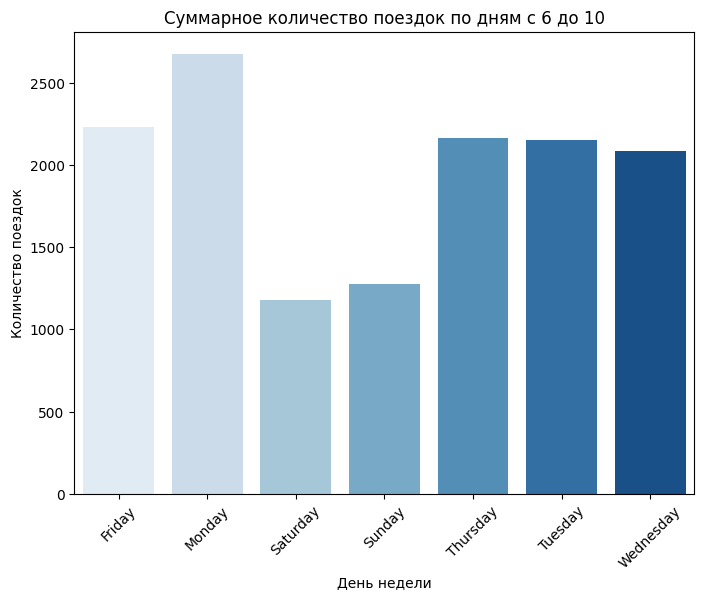

In [153]:
# 3) Вывожу барплот по дням с 6 до 10
morning_trips = merged.loc[(merged['datetime'].dt.hour >= 6) & (merged['datetime'].dt.hour < 10), :]
morning_trips = morning_trips.groupby(morning_trips['datetime'].dt.day_name())['price'].count().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='datetime', y='price', data=morning_trips, palette='Blues')
plt.title('Суммарное количество поездок по дням с 6 до 10')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.show()

In [127]:
# 4) Нахожу долю типов, кто юзанул промо в понедельник
monday_promo_share = merged.loc[merged['promo'] == 1, 'price'].count() / merged['promo'].count()

monday_promo_share

0.019625765107012284

In [142]:
workdays = [2, 3, 4, 5]  # Индексы рабочих дней (вторник - пятница)
trips_per_workday = merged.loc[merged['day_of_week'].isin(workdays), :]
trips_per_workday = trips_per_workday.groupby('day_of_week')['id'].count().reset_index()

average_trips = trips_per_workday['id'].sum() * monday_promo_share * 30

print('Средняя потеря за день, если бы люди использовали промокод каждый рабочий день')
average_trips

Средняя потеря за день, если бы люди использовали промокод каждый рабочий день


28550.18927412398

In [155]:
# 6) Сравниваю 2 и 5 пункт
print(f"Затраты на поездки с промокодом в понедельник: {monday_promo}")
print(f"Средние затраты на поездоки с предпологаемым промокодом по другим будням с 6 до 10: {average_trips.round()}")

Затраты на поездки с промокодом в понедельник: 57330
Средние затраты на поездоки с предпологаемым промокодом по другим будням с 6 до 10: 28550.0


In [156]:
# однако посчитаем, сколько днег принес понедельник и сколько в среднем другой день

# Сумма выручки в понедельник
monday_sum = merged.loc[merged['day_of_week'] == 1, 'price'].sum()
print(f"Сумма выручки в понедельник: {monday_sum}")

# Средняя сумма выручки в другие дни
other_days_mean = merged.loc[merged['day_of_week'].isin(workdays), 'price'].groupby(merged['day_of_week']).sum().mean()
print(f"Средняя сумма выручки в другие дни: {other_days_mean.round(1)}")

Сумма выручки в понедельник: 2022061.8
Средняя сумма выручки в другие дни: 2007842.1


In [158]:
# итого в понедельник выручки больше на столько процентов
print(((monday_sum - other_days_mean) / other_days_mean) * 100)

0.7082074537372154


### Итого, несмотря на то, что в понедельник затраты на промокоды почти в 2 раза больше,чем предполагаемые затраты в другой день недели, за все время эта акция принесла нам дополнительно около 15 тысяч рублей. Поэтому необходимо также внедрить ее в другие дни

# Регрессия

In [ ]:

weather_for_regression = weather.copy()
merged_for_regression = merged.copy()

hourly_demand = merged_for_regression.resample('H', on='datetime').aggregate({'id':'count', 'promo':'max'})

hourly_demand.reset_index(inplace=True)



In [ ]:
hourly_demand.columns = ['datetime', 'demand', 'promo']

hourly_demand

In [ ]:
data_for_regression = pd.merge(weather_for_regression, hourly_demand, on='datetime', how='inner')

# добавляем столбец дня недели
data_for_regression['week_day'] = data_for_regression['datetime'].map(lambda x : x.isoweekday())

data_for_regression

In [ ]:
# проверим корректность промокода

filtered_rows = data_for_regression.loc[(data_for_regression['week_day'] == 1) &
                                           (data_for_regression['datetime'].dt.hour >= 6) &
                                           (data_for_regression['datetime'].dt.hour < 9)]

filtered_rows.shape

все хорошо

In [ ]:
data_for_regression.head(10)

In [ ]:
def linear_predict(data, target, categories_data=[]):
    params = [cat for cat in data.columns if cat not in target]

    # Определение признаков и целевой переменной
    X = merged_sorted[features_cols]
    y = merged_sorted[target_col]

    # Разделение данных на обучающую и тестовую выборки
    train_size = int(0.8 * len(merged_sorted))  # 80% для обучения
    x_train, x_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore').set_output(transform='pandas')

    if categories_data:
        x_train_encoded = ohe.fit_transform(x_train[categories_data])
        x_test_encoded = ohe.transform(x_test[categories_data])

        not_categories_list = [cat for cat in params if cat not in categories_data]

        x_train = pd.concat([x_train[not_categories_list], pd.DataFrame(x_train_encoded)], axis=1)
        x_test = pd.concat([x_test[not_categories_list], pd.DataFrame(x_test_encoded)], axis=1)

    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    prediction = linreg.predict(x_test)

    return prediction, linreg, y_test

In [ ]:
# удаляем лишние столбцы
data_for_regression = data_for_regression.drop(columns=['wind_speed', 'sunshine_duration'])

# Сортировка датасета по столбцу 'datetime'
merged_sorted = data_for_regression.sort_values(by='datetime')

merged_sorted['datetime'] = merged_sorted['datetime'].dt.hour

# Определение целевой переменной
target_col = 'demand'

# определение факторов
features_cols = ['datetime', 'temperature', 'precipitation_total', 'wind_gust', 'cloud_cover_total', 'promo', 'week_day']

# категориальные факторы
category = ['datetime', 'promo', 'week_day']

preds, linreg, y_test = linear_predict(merged_sorted, target_col, categories_data=category)



In [ ]:
data_for_regression

In [ ]:
preds = np.round(preds)
preds

In [ ]:
# рассчитаем процент совпадений
acc = accuracy(y_test, preds)

# Рассчитываем коэффициент детерминации
r2 = r2_score(y_test, preds)

# Рассчитываем среднеквадратичную ошибку (MSE)
mse = mean_squared_error(y_test, preds)

# Рассчитываем среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(y_test, preds)

# Рассчитываем коэффициент корреляции Пирсона
corr = np.corrcoef(y_test, preds)[0, 1]

# Выводим результаты
print("процент совпадений:", acc)
print("Коэффициент детерминации:", r2)
print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Коэффициент корреляции Пирсона:", corr)


In [ ]:
sns.regplot(y=preds, x=y_test)
plt.ylabel('predictions')
plt.title('Зависимость предсказанного спроса от реального')

In [ ]:
# Вычисление оштбки для каждого предсказания
mse_list = preds - y_test

sns.regplot(x=y_test, y=mse_list)
plt.xlabel('demand')
plt.ylabel('Разница предсказания и реальности')
plt.title('Зависимость ошибки от спроса')
plt.show()

In [ ]:
sns.histplot(mse_list, kde=True)
plt.title('Распределение ошибок')
plt.xlabel('Разница между предсказанием и реальностью')

In [ ]:
linreg.coef_

## Вывод

Факторы, которые мы выбрали, а именно: время, температура, осадки, промокод, облачностьт, порывы ветра, день недели, могут описывать спрос. Моджель имеет высокий коэфф детерминации, что говорит нам о качестве описания закономерности. При анализе ошибок зависимость предсказанного спроса от реального довольно близка в диагонали, где предсказания и реальные данные совпадают, однако при оценке зависимости различия предсказания и реальности была выявлена несовершенность модели. Форма графика говорит нам о том, что модель плохо предсказывает высокий спрос (почти нормальное распределение, но есть хвост значений в отрицательную сторону, то есть предсказала меньше, чем было). Также мы включали в модель временные факторы, результат может свидетельствовать о возможном наличии неких временных трендов и сезонностей. Однако основная цель заключалась в выявлении параметров, от которых зависит спрос. Задачу мы успешно выполнили, поэтому я считаю, что все прошло успешно, поставленных целей мы достигли.

# Проверка гипотез

## 1. Н0: количество поездок не зависит от месяца

In [ ]:
# посмотрим на данные
months_dev = merged['datetime'].apply(lambda x: x.month).value_counts().reset_index(inplace=False)
months_dev

Видим что количество поездок увеличивается с каждым месяцем

In [ ]:
sns.barplot(x=months_dev['count'], y=months_dev.datetime)

plt.title('Количество поездок по месяцам')
plt.ylabel('частота')
plt.xlabel('месяц')


In [ ]:
new = merged['datetime'].apply(lambda x: x.month)

# Пример ожидаемого равномерного распределения
obs = months_dev['count']
expected = [len(new) / len(new.unique())] * len(new.unique())

# Выполнение теста согласия хи-квадрат
chi2_stat = stats.chisquare(f_obs=obs, f_exp=expected)

chi2_stat

In [ ]:
expected

In [ ]:
obs

In [ ]:
# очевидно, что в апреле спрос будет гораздо меньше, так как там еще есть снег, слякоть и грязь, проверим гипотезу без него

new = merged['datetime'].apply(lambda x: x.month)

# Пример ожидаемого равномерного распределения
obs = months_dev[months_dev['datetime'] > 4]['count']
expected = [sum(obs) / len(months_dev[months_dev['datetime'] > 4]['datetime'].unique())] * len(
    months_dev[months_dev['datetime'] > 4]['datetime'].unique())

# Выполнение теста согласия хи-квадрат
chi2_stat = stats.chisquare(f_obs=obs, f_exp=expected)

chi2_stat

### вывод: отклоняем 0 гипотезу (p-value < 0.05)

## 2. Н0: средняя стоимость поездок не отличается по районам

In [ ]:
# сгруппируем данные по районам
f = merged.groupby('start_district', as_index=False)['price'].mean().sort_values('price')

sns.barplot(y=f['start_district'], x=f['price'], orient='h')
plt.title('Средняя цена поездок по регионам (в точке старта)')

In [ ]:
merged.groupby('start_district', as_index=False)['price'].count()

In [ ]:
merged.groupby('end_district', as_index=False)['price'].count()

In [ ]:
z = merged.groupby('end_district', as_index=False)['price'].mean().sort_values('price')

sns.barplot(y=z['end_district'], x=z['price'], orient='h')
plt.title('Средняя цена поездок по регионам (в точке финиша)')

заметим, что отличается. Проверяем аналитически


In [ ]:
districts = merged['start_district'].unique()

start_groups = []

for district in districts:  # создаем группы цен по регионам старта
    start_groups.append(merged.loc[merged['start_district'] == district, 'price'].to_list())


end_groups = []

for district in districts:  # создаем группы цен по регионам финиша
    end_groups.append(merged.loc[merged['end_district'] == district, 'price'].to_list())

In [ ]:
# разбивка на группы
def sampling(groups):

    shaffled_groups = []
    for i in groups:
        # Случайным образом выберите N значений из массива данных
        gr = np.random.choice(i, size=5000, replace=False)
        shaffled_groups.append(gr)
    return shaffled_groups

In [ ]:
# функция для теста
def check_months_dev(groups):
    fl = True  # флаг, отвечающий за норамльность

    for group in groups:  # проверяем нормальность
        if stats.shapiro(group)[1] < 0.05:
            fl = False
    if fl:
        p_value = stats.f_oneway(*groups)[1]  # если норм распределены все группы, используем ANOVA
        method = 'ANOVA'
    else:
        p_value = stats.kruskal(*groups)[1]  # иначе критерий Краскела-Уоллеса
        method = 'критерий Краскела-Уоллеса'

    return p_value, method


# ANOVA и тест Краскелла-Уоллеса работает на данных одинаковой длины
# поэтому я случайно сформирую 1000 выборок длины 5000 (иначе тест может работать не корректно)
# для каждого региона и буду закидывать их в тест, записывая p-value
start_values = []
end_values = []
s_method = []
e_method = []


for _ in range(1000):
    start = sampling(start_groups)
    end = sampling(end_groups)

    p_value1, m1 = check_months_dev(start)
    p_value2, m2 = check_months_dev(end)

    start_values.append(p_value1)
    end_values.append(p_value2)
    s_method.append(m1)
    e_method.append(m2)



In [ ]:
sns.kdeplot(start_values)
plt.xlabel('p-value')
plt.ylabel('вероятность')
plt.title('Распределение p-value тестов по начальнам локациям')

In [ ]:
s_method = pd.Series(s_method).value_counts()
sns.barplot(x=s_method.index, y=s_method.values)

plt.xlabel('Метод')
plt.ylabel('Количество')
plt.title('Статистические тесты по стартовым локациям')

In [ ]:
pd.DataFrame(start_values).describe()

In [ ]:
sns.kdeplot(end_values)
plt.xlabel('p-value')
plt.ylabel('вероятность')
plt.title('Распределение p-value тестов по конечным локациям')

In [ ]:
e_method = pd.Series(e_method).value_counts()
sns.barplot(x=e_method.index, y=e_method.values)

plt.xlabel('Метод')
plt.ylabel('Количество')
plt.title('Статистические тесты по финишным локациям')

In [ ]:
pd.DataFrame(end_values).describe()

### Вывод: 0 гипотеза отвергается

## 3. Н0: среднее кол-во поездок одинаково каждый день недели

In [ ]:
# создадим в merged столбцец дня недели
merged['day_of_week'] = merged['datetime'].map(lambda x: x.isoweekday())
merged


In [ ]:
# Функции mean_ver возращают DataFrame, где среднее кол-во поездок по дням недели и часам
# В них передаются категория start_ или end_time и в mean_ver_2 дополнительно Локация(Улица или Район)
# Эти DataFrames использовать с groupby или выборка
def mean_ver_1(time_base):
    demand = []
    for i in range(1, 9):
        demand.append([[0] * 24, set()])

    for i in merged[time_base]:
        demand[i.weekday() + 1][0][i.hour] += 1
        demand[i.weekday() + 1][1].add(i.isocalendar().week)

    demand_res = []

    for i in range(1, 8):
        for j in range(24):
            demand_res.append(
                [i, j, round(demand[i][0][j] / len(demand[i][1]))]
            )
    return pd.DataFrame(demand_res, columns=["day", "hour", "mean"])

def men_ver_2(location, time_base):
    demand = {}
    streets = list(set(merged[location]))

    for loc in streets:
        demand[loc] =  []
        for i in range(1, 9):
            demand[loc].append([[0] * 24, set()])

    for loc, time in zip(merged[location], merged[time_base]):
        demand[loc][time.weekday() + 1][0][time.hour] += 1
        demand[loc][time.weekday() + 1][1].add(time.isocalendar().week)

    demand_res = []

    for loc in streets:
        for day in range(1, 7):
            for hour in range(24):
                demand_res.append(
                    [loc, day, hour, round(demand[loc][day][0][hour] / len(demand[loc][day][1]))]
                )

    return pd.DataFrame(demand_res, columns=["location", "day", "hour", "mean"])


In [ ]:
mean_value = mean_ver_1("start_date")
mean_value

Сначала проверим будние дни

In [ ]:
palette = sns.color_palette(n_colors=5)

# 1 - понеделеьник, ... , 7 - воскресенье
# выведем график для будней
sns.lineplot(data=mean_value[mean_value["day"] <= 5], x="hour", y="mean", legend=True, hue='day', palette=palette)

plt.title('Среднее количество поездок в час по будням')

В понедельник пик с 7 до 10 утра, в пятницу тоже больше спрос, но после рабочего дня - с 17 часов. Теперь проверим по выходным дням

In [ ]:
palette = sns.color_palette("Set2", n_colors=2)

# выведем график для выходных
sns.lineplot(data=mean_value[mean_value["day"] > 5], x="hour", y="mean", legend=True, hue='day', palette=palette)

plt.title('Среднее количество поездок в час по выходным')

В выходные явно больше поездок, проверим статистически. При проверке будем не будем учитывать данные с 0 до 6, так как ночью в принципе мало поездок и почти у всех графиков совпадает этот участок (кроме выходных, там люди активны почти до 3 утра)

In [ ]:
data_for_statistic = merged.groupby(['day_of_week'], as_index=False).agg({'hourly_count':'sum'})
data_for_statistic

In [ ]:
# Пример ожидаемого равномерного распределения
obs = data_for_statistic['hourly_count']
expected = [sum(data_for_statistic['hourly_count']) / len(
    data_for_statistic['day_of_week'].unique())] * len(data_for_statistic['day_of_week'].unique())

# Выполнение теста согласия хи-квадрат
chi2_stat = stats.chisquare(f_obs=obs, f_exp=expected)

chi2_stat

### Вывод: Н0 отвергается

## 4. Н0: в дождливую и сухую погоду спрос на самокаты одинаковый

In [ ]:
# добавим в merged столбец дня и столбец с часом
merged['day'] = merged['datetime'].dt.floor('d')
merged['hour'] = merged['datetime'].dt.hour

merged

In [ ]:
weather.temperature.min()


если мы будем суммарный спрос за день, то для солнечных дней он будет больше только за счёт того, что статистически таких дней больше. Здесь нужно смотреть на средний почасовой спрос. При этом гипотезу логичнее проверять на дневном времени, поскольку люди ездят как правило днём и именно там можно наблюдать разницу, в ночное время ее отследить сложнее, и это будет смазывать результаты.

In [ ]:
# момент, когда осадки больше 0 и температура >= 0, будем считать дождливой погодой
# момент, когда осадки = 0 и температура >= 0, будем считать сухой погодой
# Будем учитывать данные только с 7 утра
rainy_hours = merged.loc[(merged['precipitation_total'] > 0) & (merged['temperature'] >= 0) & (merged['hour'] >= 7), ['hourly_count', 'day']]
drought_hours = merged.loc[(merged['precipitation_total'] == 0) & (merged['temperature'] >= 0) & (merged['hour'] >= 7), ['hourly_count', 'day']]

In [ ]:
# сгруппируем данные по дню и найдем суммарный спрос дня
rainy_hours = rainy_hours.groupby('day', as_index=False).agg({'hourly_count':'sum'})
drought_hours = drought_hours.groupby('day', as_index=False).agg({'hourly_count':'sum'})


In [ ]:
sns.boxplot([rainy_hours['hourly_count'], drought_hours['hourly_count']])

plt.xticks([0, 1], ['Дождливые', 'Сухие'])
plt.title('Распределение спроса в дождливые и сухие дни')
plt.ylabel('Cпрос')

In [ ]:
def rain_vs_drought(group1, group2):
    if stats.shapiro(group1)[1] >= 0.05 and stats.shapiro(group2)[1] >= 0.05:  # если данные распределены нормально, то Стьюдент
        value = stats.ttest_ind(group1, group2, equal_var=False, alternative='two-sided')[1]
        print('Стьюдент')
    else:  # иначе Манн-Уитней
        value = stats.mannwhitneyu(group1, group2, alternative='two-sided')[1]
        print('Манн-Уитней')
    return value

print(rain_vs_drought(rainy_hours['hourly_count'], drought_hours['hourly_count']))

Манн-Уитней
9.303417570383662e-13


### Вывод: Н0 отвергается (p-value < 0.05)

## 5. Н0: в выходные и будни поездки длятся одинаково долго


In [ ]:
def holidays_vs_workdays(group1, group2):
    if stats.shapiro(group1)[1] >= 0.05 and stats.shapiro(group2)[1] >= 0.05:  # если данные распределены нормально, то Стьюдент
        value = stats.ttest_ind(group1, group2, equal_var=False, alternative='two-sided')[1]
        m = 'Стьюдент'
    else:  # иначе Манн-Уитней
        value = stats.mannwhitneyu(group1, group2, alternative='two-sided')[1]
        m = 'Манн-Уитней'
    return value, m

In [ ]:
holidays = merged.loc[merged['day_of_week'] > 5, ['trip_time_minutes']]
workdays = merged.loc[merged['day_of_week'] <= 5, ['trip_time_minutes']]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

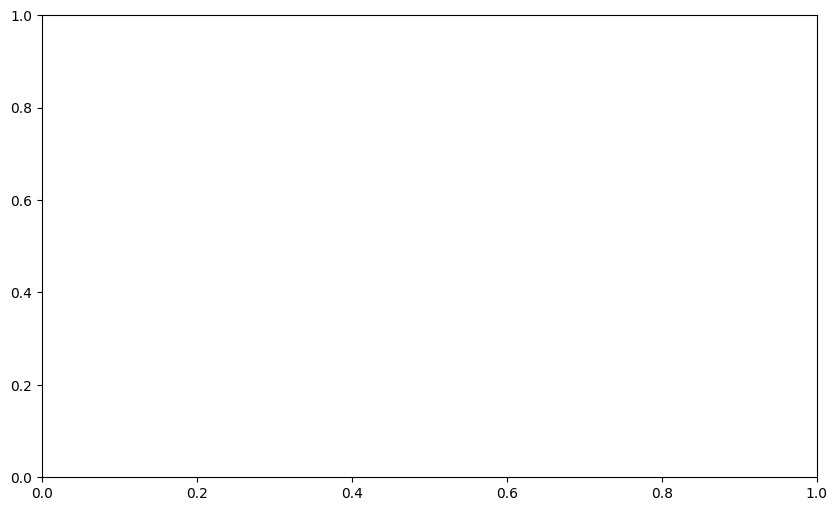

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x=['Выходные', 'Будни'], y=[holidays, workdays], ax=ax)

plt.xticks([0, 1], ['Выходные', 'Будни'])
plt.title('Продолжительность поездок в выходные и будни')
plt.ylabel('Продолжительность поездок, мин')

In [ ]:
merged.loc[merged['trip_time_minutes'] >= 45, ['trip_time_minutes', 'distance', 'speed']].describe()

,trip_time_minutes,distance,speed
count,4885.000000,4885.000000,4885.000000
mean,53.627568,5232.759963,5.952000
std,8.208728,1165.301058,1.448745
min,45.000000,2014.000000,2.279973
25%,47.470000,4386.345215,4.938733
50%,50.920000,5141.000000,5.875728
75%,57.370000,5943.000000,6.885164
max,84.830000,24993.307692,23.752880


все что ящик обозначил как выбросы - не выбосы, так что все хорошо

In [ ]:
values = []
method = []

for i in range(1000):  # 1000 выборок по 5к элементов для корректности работы метода
    value, m = holidays_vs_workdays(*sampling([holidays['trip_time_minutes'], workdays['trip_time_minutes']]))
    values.append(value)
    method.append(m)

Text(0.5, 1.0, 'Распределение p-value тестов')

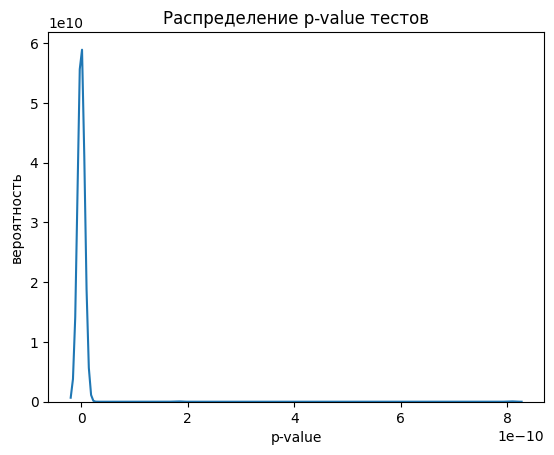

In [ ]:
sns.kdeplot(values)
plt.xlabel('p-value')
plt.ylabel('вероятность')
plt.title('Распределение p-value тестов')

Text(0.5, 1.0, 'Статистические тесты')

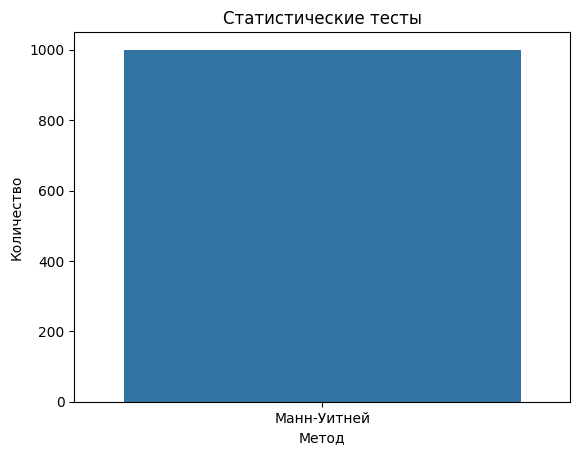

In [ ]:
method = pd.Series(method).value_counts()
sns.barplot(x=method.index, y=method.values)

plt.xlabel('Метод')
plt.ylabel('Количество')
plt.title('Статистические тесты')

In [ ]:
pd.DataFrame(values).describe()

,0
count,1.000000e+03
mean,1.004572e-12
std,2.615579e-11
min,7.704511e-41
25%,9.804214e-25
50%,4.797230e-22
75%,1.026939e-19
max,8.072069e-10


### Вывод: Н0 отвергнута (p-value < 0.05)

## 6. H0: скорости поездок в будние дни и выходные одинаковы

In [ ]:
# гипотеза аналогична 5, доказываем
holidays = merged.loc[merged['day_of_week'] > 5, ['speed']]
workdays = merged.loc[merged['day_of_week'] <= 5, ['speed']]

In [ ]:
sns.boxplot([holidays, workdays])

plt.xticks([0, 1], ['Выходные', 'Будни'])
plt.title('Скорость поездок в выходные и будни')
plt.ylabel('Скорость поездок, км/ч')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
values = []
method = []

for i in range(1000):  # 1000 выборок по 5к элементов для корректности работы метода
    value, m = holidays_vs_workdays(*sampling([holidays['speed'], workdays['speed']]))
    values.append(value)
    method.append(m)

Text(0.5, 1.0, 'Распределение p-value тестов скорости по частям недели')

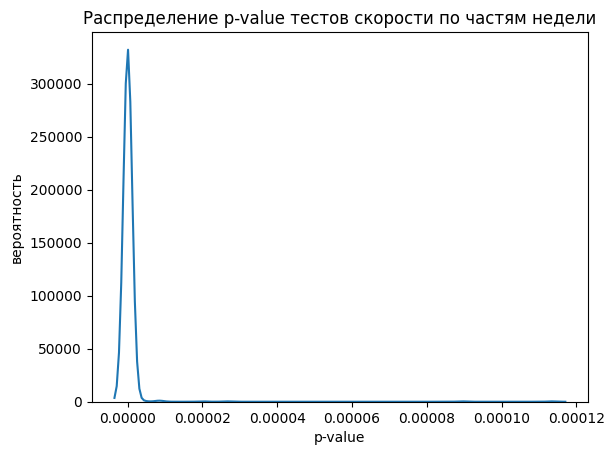

In [ ]:
sns.kdeplot(values)
plt.xlabel('p-value')
plt.ylabel('вероятность')
plt.title('Распределение p-value тестов скорости по частям недели')

Text(0.5, 1.0, 'Статистические тесты скорости по частям недели')

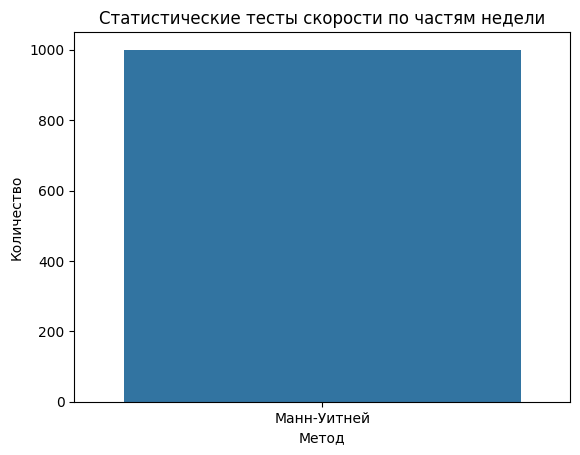

In [ ]:
method = pd.Series(method).value_counts()
sns.barplot(x=method.index, y=method.values)

plt.xlabel('Метод')
plt.ylabel('Количество')
plt.title('Статистические тесты скорости по частям недели')

In [ ]:
pd.DataFrame(values).describe()

,0
count,1.000000e+03
mean,3.076429e-07
std,4.709799e-06
min,6.866958e-26
25%,4.005014e-14
50%,6.015133e-12
75%,4.711732e-10
max,1.135169e-04


### Вывод: Н0 отвергаем (p-value <0.05)

Оценивайте как хотите, в работе помогал только ментор, я ее делал 1. Я - Шаклеин Игнат Эдуардович